In [2]:
from typing import List, Tuple
import os
import json
import re
from collections import Counter
from tqdm import tqdm

In [3]:
def extract_keywords(
    keywords_list: List[str] = [
        "wait",
        "re-check",
        "recheck",
        "rethink",
        "re-think",
        "reconsider",
        "re-consider",
        "re-evaluat",
        "reevaluat",
        "rethink",
        "re-think",
        "re-examine",
        "reexamine",
        "check again",
        "try again",
        "think again",
        "consider again",
        "evaluate again",
        "examine again",
    ],
    response_dir: str = "./reflect_responses",
):
    """
    Extracts keywords from responses stored in JSON files within the specified directory.

    Args:
        keywords_list (List[str], optional): A list of keywords to search for in the responses.
            Defaults to [
                "wait", "re-check", "recheck", "rethink", "re-think", "reconsider",
                "re-consider", "re-evaluat", "reevaluat", "rethink", "re-think",
                "re-examine", "reexamine", "check again", "try again", "think again",
                "consider again", "evaluate again", "examine again",
            ].
        response_dir (str, optional): The directory containing JSON response files.
            Defaults to "./reflect_responses".

    Returns:
        dict: A dictionary where keys are keywords and values are their respective counts
            in the responses.
    """
    # most keywords only appear in responses containing the word "wait"
    # Moreover, we observe that the majority of these instances involve the word "wait" preceding other keywords.
    # Furthermore, nearly all identified keywords co-occur with the word "wait" within the same sentence.
    keywords = []
    first_occurrence = []
    first_occurrence_this_sentence = []
    first_occurrence_wo_wait = []
    last_sentence_flag = False
    for idx, response_file in enumerate(tqdm(os.listdir(response_dir))):
        with open(os.path.join(response_dir, response_file), "r") as f:
            response = json.load(f)["response"]
            sentences = re.split(r"(?<=[.!?:])\s+", response)
            for idy, sentence in enumerate(sentences):
                this_sentence_flag = False
                for keyword in keywords_list:
                    if keyword in sentence.lower():
                        keywords.append(keyword)
                        if not this_sentence_flag:
                            this_sentence_flag = True
                            first_occurrence_this_sentence.append(keyword)
                            if not last_sentence_flag:
                                first_occurrence.append(keyword)
                            if idy > 0 and "wait" not in sentences[idy - 1].lower():
                                first_occurrence_wo_wait.append(keyword)
                last_sentence_flag = this_sentence_flag

    return (
        dict(Counter(keywords)),
        dict(Counter(first_occurrence)),
        dict(Counter(first_occurrence_wo_wait)),
        dict(Counter(first_occurrence_this_sentence)),
    )

In [4]:
def response_length(
    tokenizer, response_dir="./reflect_responses", divide_by_wait=False
):
    """
    Calculates the average length of responses stored in JSON files within the specified directory.

    Returns:
        float: The average length of responses.
    """
    response_lengths = [[], []] if divide_by_wait else []
    for response_file in os.listdir(response_dir):
        with open(os.path.join(response_dir, response_file), "r") as f:
            result = json.load(f)
            response = result["response"]
            problem = result["problem"]
            response_length = (
                tokenizer(response, return_tensors="pt")["input_ids"].shape[1]
                - tokenizer(problem, return_tensors="pt")["input_ids"].shape[1]
            )
            if divide_by_wait:
                if "wait" in response.lower():
                    response_lengths[0].append(response_length)
                else:
                    response_lengths[1].append(response_length)
            else:
                response_lengths.append(response_length)
    return response_lengths

In [5]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [9]:
response_length_list = []
for response_dir in ["reflect_responses", "long_responses", "long_responses2"]:
    response_length_list.append(response_length(tokenizer, response_dir=response_dir, divide_by_wait=True))

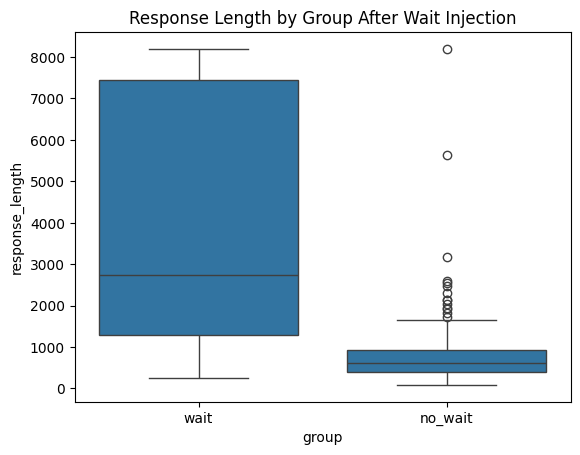

In [12]:
import seaborn as sns
import pandas as pd

# Combine the two lists into a DataFrame with columns "wait" and "no_wait"
df_wait = pd.DataFrame({"response_length": response_length_list[1][0]})
df_wait["group"] = "wait"

df_no_wait = pd.DataFrame({"response_length": response_length_list[1][1]})
df_no_wait["group"] = "no_wait"

# Concatenate the two DataFrames vertically.
df_plot = pd.concat([df_wait, df_no_wait], ignore_index=True)

sns.boxplot(x="group", y="response_length", data=df_plot)
import matplotlib.pyplot as plt
plt.title("Response Length by Group After Wait Injection")
plt.show()

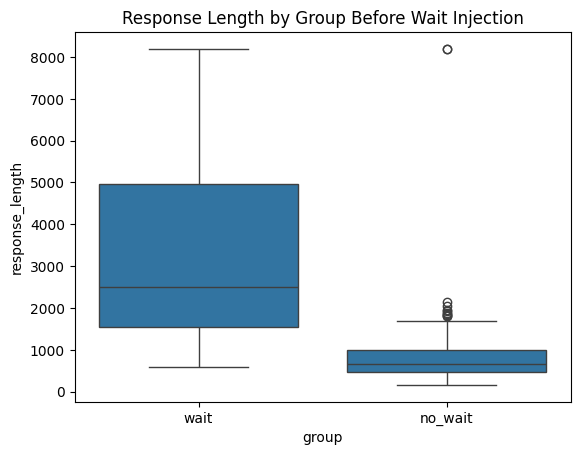

In [14]:
import seaborn as sns
import pandas as pd

# Combine the two lists into a DataFrame with columns "wait" and "no_wait"
df_wait = pd.DataFrame({"response_length": response_length_list[2][0]})
df_wait["group"] = "wait"

df_no_wait = pd.DataFrame({"response_length": response_length_list[2][1]})
df_no_wait["group"] = "no_wait"

# Concatenate the two DataFrames vertically.
df_plot = pd.concat([df_wait, df_no_wait], ignore_index=True)

sns.boxplot(x="group", y="response_length", data=df_plot)
import matplotlib.pyplot as plt
plt.title("Response Length by Group Before Wait Injection")
plt.show()

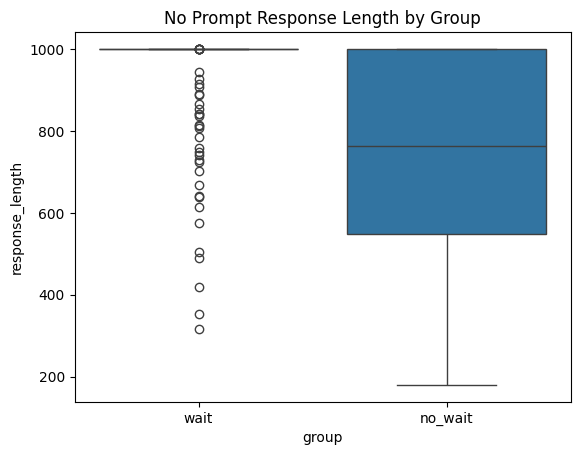

In [13]:
import seaborn as sns
import pandas as pd

# Combine the two lists into a DataFrame with columns "wait" and "no_wait"
df_wait = pd.DataFrame({"response_length": response_length_list[0][0]})
df_wait["group"] = "wait"

df_no_wait = pd.DataFrame({"response_length": response_length_list[0][1]})
df_no_wait["group"] = "no_wait"

# Concatenate the two DataFrames vertically.
df_plot = pd.concat([df_wait, df_no_wait], ignore_index=True)

sns.boxplot(x="group", y="response_length", data=df_plot)
import matplotlib.pyplot as plt
plt.title("No Prompt Response Length by Group")
plt.show()

In [16]:
def count_wait(response_dir: str = "./reflect_responses"):
    """
    Count the number of responses that contain the word "wait".

    Args:
        response_dir (str, optional): The directory containing JSON response files.
            Defaults to "./reflect_responses".

    Returns:
        int: The number of responses that contain the word "wait".
    """
    counts = []
    for response_file in os.listdir(response_dir):
        with open(os.path.join(response_dir, response_file), "r") as f:
            response = json.load(f)["response"]
            wait_count = response.lower().count("wait")
            counts.append(wait_count)
    return counts

In [25]:
counts = []
for response_dir in ["reflect_responses", "long_responses", "long_responses2"]:
    counts.append(count_wait(response_dir))
    print(f"Number of responses containing the word 'wait' in {response_dir}: {sum(count_wait(response_dir))}")

Number of responses containing the word 'wait' in reflect_responses: 891
Number of responses containing the word 'wait' in long_responses: 644
Number of responses containing the word 'wait' in long_responses2: 3683


In [17]:
counts = []
for response_dir in ["icv"]:
    counts.append(count_wait(response_dir))
    print(f"Number of responses containing the word 'wait' in {response_dir}: {sum(count_wait(response_dir))}")

Number of responses containing the word 'wait' in icv: 12733


| l | inside  | outside |
|---|---------|---------|
| 1 | 50.0%   | 50.0%   |
| 2 | 75.0%   | 25.0%   |
| 3 | 87.5%   | 12.5%   |
|4  | 93.75% |  6.25%|
|5 | 96.875% |  3.125%|
|6 | 98.438%  | 1.562%|
|7 | 99.219%  | 0.781%|

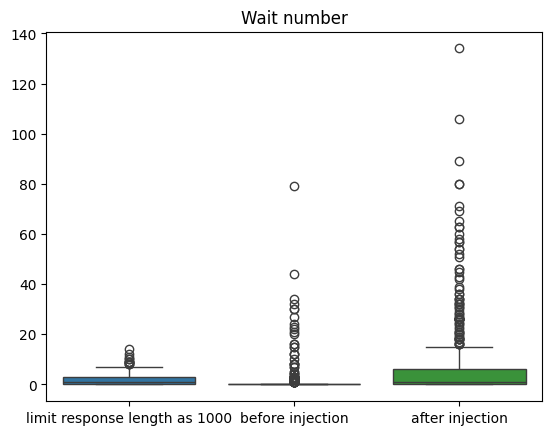

In [26]:
df_counts = pd.DataFrame({
    "limit response length as 1000": counts[0],
    "before injection": counts[1],
    "after injection": counts[2]
})
sns.boxplot(data=df_counts)
plt.title("Wait number")
plt.show()

In [ ]:
def extract_keywords(
    keywords_list: List[str] = [
        "wait",
        "re-check",
        "recheck",
        "rethink",
        "re-think",
        "reconsider",
        "re-consider",
        "re-evaluat",
        "reevaluat",
        "rethink",
        "re-think",
        "re-examine",
        "reexamine",
        "check again",
        "try again",
        "think again",
        "consider again",
        "evaluate again",
        "examine again",
    ],
    response_dir: str = "./reflect_responses",
):
    """
    Extracts keywords from responses stored in JSON files within the specified directory.

    Args:
        keywords_list (List[str], optional): A list of keywords to search for in the responses.
            Defaults to [
                "wait", "re-check", "recheck", "rethink", "re-think", "reconsider",
                "re-consider", "re-evaluat", "reevaluat", "rethink", "re-think",
                "re-examine", "reexamine", "check again", "try again", "think again",
                "consider again", "evaluate again", "examine again",
            ].
        response_dir (str, optional): The directory containing JSON response files.
            Defaults to "./reflect_responses".

    Returns:
        dict: A dictionary where keys are keywords and values are their respective counts
            in the responses.
    """
    # most keywords only appear in responses containing the word "wait"
    # Moreover, we observe that the majority of these instances involve the word "wait" preceding other keywords.
    # Furthermore, nearly all identified keywords co-occur with the word "wait" within the same sentence.
    keywords = []
    for idx, response_file in enumerate(tqdm(os.listdir(response_dir))):
        with open(os.path.join(response_dir, response_file), "r") as f:
            response = json.load(f)["response"]
            sentences = re.split(r"(?<=[.!?:])\s+", response)
            for idy, sentence in enumerate(sentences):
                for keyword in keywords_list:
                    if keyword in sentence.lower():
                        keywords.append(keyword)
    return (
        dict(Counter(keywords)),
    )

In [ ]:
for response_dir in ["reflect_responses", "long_responses", "long_responses2"]:
    print(extract_keywords(response_dir=response_dir))

100%|██████████| 500/500 [00:00<00:00, 7703.01it/s]


({'wait': 887, 'think again': 23, 'check again': 8, 're-examine': 7, 'reconsider': 3, 'try again': 1},)


100%|██████████| 500/500 [00:00<00:00, 7268.02it/s]


({'wait': 641, 're-examine': 16, 'check again': 4, 'think again': 5, 'reconsider': 12, 're-evaluat': 10, 'try again': 1, 'rethink': 2, 'recheck': 1},)


100%|██████████| 500/500 [00:00<00:00, 3790.33it/s]

({'wait': 3641, 're-evaluat': 4, 'think again': 49, 're-examine': 14, 'reconsider': 3, 'recheck': 2, 'check again': 6, 'try again': 2},)


In [ ]:
def count_keyword(response_dir: str = "./reflect_responses", keyword: str = "wait"):
    """
    Count the number of responses that contain the word "wait".

    Args:
        response_dir (str, optional): The directory containing JSON response files.
            Defaults to "./reflect_responses".

    Returns:
        int: The number of responses that contain the word "wait".
    """
    # TODO: count boxed
    counts = []
    for response_file in os.listdir(response_dir):
        with open(os.path.join(response_dir, response_file), "r") as f:
            response = json.load(f)["response"]
            wait_count = response.lower().count(keyword) 
            counts.append(wait_count)
    return counts